# Лабораторная работа №7 (Проведение исследований с моделями семантической сегментации)

Для обучения модели сегментации была выбрана задача разметки питомцев из датасета Oxford-IIIT Pet Dataset, так как:

+ Датасет легко доступен: загружается напрямую через torchvision.datasets, не требует авторизации или подтверждения условий (на русский номер невозможно подтвердить, изначально хотел Carvana Image Masking Challenge), в отличие от некоторых Kaggle-датасетов.

+ Задача подходит для бинарной и многоклассовой сегментации: сегментация включает как область объекта (животного), так и фон, это подходит для проверки работоспособности моделей.

+ Небольшой размер: позволяет быстро обучать модель даже на ограниченных ресурсах Google Colab.

+ Размеченные маски: каждая маска имеет разметку фона, объекта и границ, что позволяет решать задачу как многоклассовую.

Для оценки качества сегментации были выбраны следующие метрики:

+ Pixel Accuracy показывает общее качество маски.

+ Mean Intersection over Union (mIoU) лучше учитывает ошибки на границах и перекрытия между классами.

In [8]:
!pip install kaggle segmentation-models-pytorch scikit-learn torch torchvision tqdm --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.1 MB/s eta 0:00:00


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import segmentation_models_pytorch as smp
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [10]:
os.makedirs('/root/.kaggle', exist_ok=True)
!chmod 600 /root/.kaggle/kaggle.json

In [13]:
class PetSegmentationDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform_img=None, transform_mask=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx])  # класс: 1..3

        if self.transform_img:
            img = self.transform_img(img)
        mask = np.array(mask)
        mask = mask - 1  # приводим к 0..2
        mask = torch.from_numpy(mask).long()
        if self.transform_mask:
            mask = self.transform_mask(mask.unsqueeze(0)).squeeze(0).long()

        return img, mask


In [14]:
base = datasets.OxfordIIITPet
DATA_DIR = '/content'

dataset = datasets.OxfordIIITPet(
    root=DATA_DIR,
    download=True,
    target_types='segmentation'
)


100%|██████████| 792M/792M [00:46<00:00, 17.2MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 8.44MB/s]


AttributeError: 'OxfordIIITPet' object has no attribute 'images'

In [15]:
all_imgs = [dataset._images[i] for i in range(len(dataset))]
all_masks = [dataset._segs[i] for i in range(len(dataset))]

imgs_train, imgs_val, masks_train, masks_val = train_test_split(
    all_imgs, all_masks, test_size=0.2, random_state=42
)

# Базовая Unet без улучшений

In [16]:
transform_img = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
transform_mask = transforms.Compose([
    transforms.Resize((128,128), interpolation=transforms.InterpolationMode.NEAREST)
])

train_ds = PetSegmentationDataset(imgs_train, masks_train, transform_img, transform_mask)
val_ds = PetSegmentationDataset(imgs_val, masks_val, transform_img, transform_mask)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

device = torch.device('cuda')
model = smp.Unet(
    encoder_name="resnet34", encoder_weights="imagenet",
    in_channels=3, classes=3
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [17]:
# Метрики качества моделей
def pixel_accuracy(preds, targets):
    preds = torch.argmax(preds, dim=1)
    return (preds == targets).float().mean().item()

def mean_iou(preds, targets, num_classes=3):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)


# Обучение

In [18]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    acc = 0.0
    miou = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item() * imgs.size(0)
            acc += pixel_accuracy(preds, masks) * imgs.size(0)
            miou += mean_iou(preds, masks) * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    acc /= len(val_loader.dataset)
    miou /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {acc:.4f}, mIoU: {miou:.4f}\n")


Val Epoch 1: 100%|██████████| 92/92 [00:03<00:00, 24.62it/s]


Epoch 1/5
Train Loss: 0.4538
Val Loss: 0.3880, Acc: 0.8491, mIoU: 0.6333



Val Epoch 2: 100%|██████████| 92/92 [00:03<00:00, 24.55it/s]


Epoch 2/5
Train Loss: 0.3527
Val Loss: 0.3572, Acc: 0.8615, mIoU: 0.6551



Val Epoch 3: 100%|██████████| 92/92 [00:04<00:00, 18.79it/s]


Epoch 3/5
Train Loss: 0.3175
Val Loss: 0.3691, Acc: 0.8559, mIoU: 0.6417



Val Epoch 4: 100%|██████████| 92/92 [00:03<00:00, 24.53it/s]


Epoch 4/5
Train Loss: 0.2997
Val Loss: 0.2991, Acc: 0.8832, mIoU: 0.6983



Val Epoch 5: 100%|██████████| 92/92 [00:03<00:00, 24.91it/s]

Epoch 5/5
Train Loss: 0.2766
Val Loss: 0.3087, Acc: 0.8837, mIoU: 0.6894



# Acc: 0.8837, mIoU: 0.6894

# Пример работы

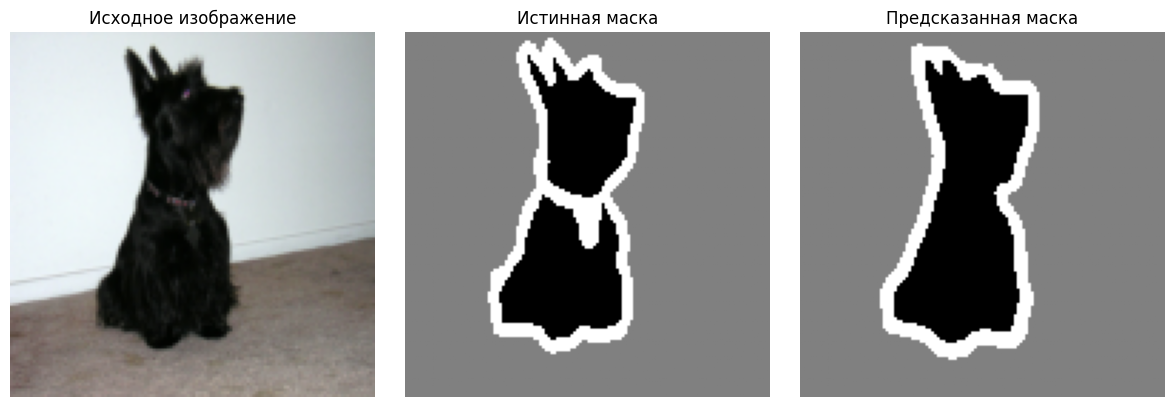

In [20]:
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, device):
    model.eval()
    img, true_mask = dataset[666]
    with torch.no_grad():
        img_input = img.unsqueeze(0).to(device)
        pred = model(img_input)
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    true_mask = true_mask.numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].set_title("Исходное изображение")
    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("Истинная маска")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Предсказанная маска")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_prediction(model, val_ds, device)


# Улучшенный Unet

Что можно улучшить:
+ Более высокое разрешение входа: (256, 256)

+ Улучшенный энкодер: efficientnet-b0

+ Аугментации: повороты, цвет

+ Комбинированная функция потерь: DiceLoss + CrossEntropyLoss

+ Планировщик ReduceLROnPlateau  
Для всех следующих моделей улучшение бейзлайна будет аналогичным


In [23]:
# Аугментации
transform_img_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

transform_img_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
])

train_ds = PetSegmentationDataset(imgs_train, masks_train, transform_img_train, transform_mask)
val_ds = PetSegmentationDataset(imgs_val, masks_val, transform_img_val, transform_mask)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

device = torch.device('cuda')
model = smp.Unet(
    encoder_name="efficientnet-b0", encoder_weights="imagenet",
    in_channels=3, classes=3
).to(device)

dice_loss = smp.losses.DiceLoss(mode='multiclass')
ce_loss = nn.CrossEntropyLoss()

def criterion(pred, target):
    return dice_loss(pred, target) + ce_loss(pred, target)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


In [25]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    acc = 0.0
    miou = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item() * imgs.size(0)
            acc += pixel_accuracy(preds, masks) * imgs.size(0)
            miou += mean_iou(preds, masks) * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    acc /= len(val_loader.dataset)
    miou /= len(val_loader.dataset)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {acc:.4f}, mIoU: {miou:.4f}\n")


Val Epoch 1: 100%|██████████| 92/92 [00:05<00:00, 16.06it/s]


Epoch 1/5
Train Loss: 0.9182
Val Loss: 0.7103, Acc: 0.8486, mIoU: 0.6204



Val Epoch 2: 100%|██████████| 92/92 [00:05<00:00, 16.01it/s]


Epoch 2/5
Train Loss: 0.8934
Val Loss: 0.6748, Acc: 0.8596, mIoU: 0.6487



Val Epoch 3: 100%|██████████| 92/92 [00:05<00:00, 15.70it/s]


Epoch 3/5
Train Loss: 0.8804
Val Loss: 0.7020, Acc: 0.8365, mIoU: 0.6156



Val Epoch 4: 100%|██████████| 92/92 [00:05<00:00, 15.91it/s]


Epoch 4/5
Train Loss: 0.8680
Val Loss: 0.7506, Acc: 0.8296, mIoU: 0.5968



Val Epoch 5: 100%|██████████| 92/92 [00:05<00:00, 16.01it/s]

Epoch 5/5
Train Loss: 0.8457
Val Loss: 0.7527, Acc: 0.8230, mIoU: 0.5814



# Acc: 0.8230, mIoU: 0.5814

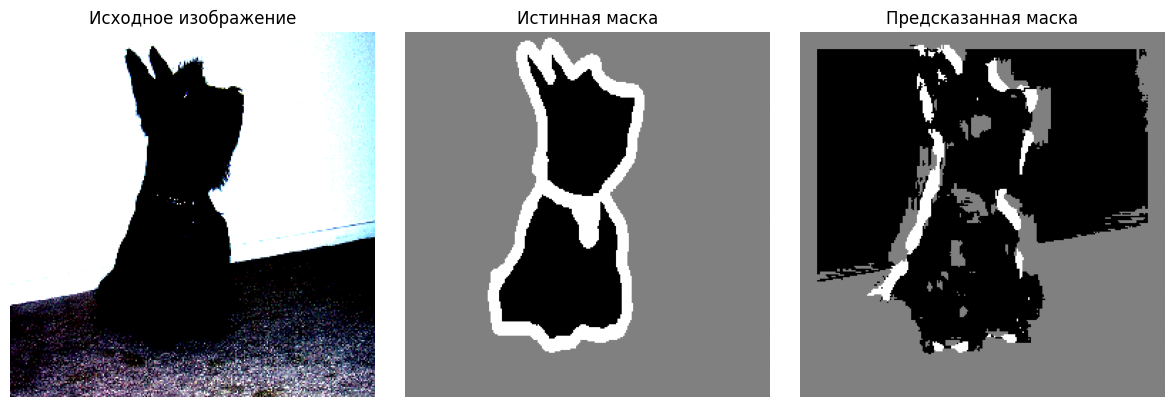

In [41]:
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, device):
    model.eval()
    img, true_mask = dataset[666]
    with torch.no_grad():
        img_input = img.unsqueeze(0).to(device)
        pred = model(img_input)
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    true_mask = true_mask.numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].set_title("Исходное изображение")
    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("Истинная маска")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Предсказанная маска")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_prediction(model, val_ds, device)


По  результатам обучения видно, что модель показалу худший результат. Вероятно, разнообразие данных, её запутало или малое количество эпох (5), не дало до конца обучиться. Либо сами преобразования ухудшили качество данных

# Кастомный Unet

In [29]:
transform_img = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
transform_mask = transforms.Compose([
    transforms.Resize((128,128), interpolation=transforms.InterpolationMode.NEAREST)
])

train_ds = PetSegmentationDataset(imgs_train, masks_train, transform_img, transform_mask)
val_ds = PetSegmentationDataset(imgs_val, masks_val, transform_img, transform_mask)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)


In [30]:
# Базовая реализация U-Net
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.down1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up_conv3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_conv2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_conv1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        b = self.bottleneck(self.pool3(d3))

        up3 = self.up3(b)
        up3 = self.up_conv3(torch.cat([up3, d3], dim=1))
        up2 = self.up2(up3)
        up2 = self.up_conv2(torch.cat([up2, d2], dim=1))
        up1 = self.up1(up2)
        up1 = self.up_conv1(torch.cat([up1, d1], dim=1))

        return self.final(up1)



In [31]:
device = torch.device('cuda')
model = UNet(in_channels=3, out_channels=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [32]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    acc = 0.0
    miou = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item() * imgs.size(0)
            acc += pixel_accuracy(preds, masks) * imgs.size(0)
            miou += mean_iou(preds, masks) * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    acc /= len(val_loader.dataset)
    miou /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {acc:.4f}, mIoU: {miou:.4f}\n")


Val Epoch 1: 100%|██████████| 92/92 [00:04<00:00, 22.05it/s]


Epoch 1/5
Train Loss: 0.8378
Val Loss: 0.6901, Acc: 0.7151, mIoU: 0.3829



Val Epoch 2: 100%|██████████| 92/92 [00:05<00:00, 16.55it/s]


Epoch 2/5
Train Loss: 0.6790
Val Loss: 0.6385, Acc: 0.7417, mIoU: 0.4516



Val Epoch 3: 100%|██████████| 92/92 [00:05<00:00, 16.31it/s]


Epoch 3/5
Train Loss: 0.6549
Val Loss: 0.6164, Acc: 0.7494, mIoU: 0.4613



Val Epoch 4: 100%|██████████| 92/92 [00:04<00:00, 19.72it/s]


Epoch 4/5
Train Loss: 0.6221
Val Loss: 0.5618, Acc: 0.7794, mIoU: 0.5007



Val Epoch 5: 100%|██████████| 92/92 [00:04<00:00, 22.15it/s]

Epoch 5/5
Train Loss: 0.5625
Val Loss: 0.6032, Acc: 0.7617, mIoU: 0.4692



# Acc: 0.7617, mIoU: 0.4692

# Улучшенный бейзлайн

In [36]:
class PetSegmentationDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.img_paths[idx]).convert('RGB'))
        mask = np.array(Image.open(self.mask_paths[idx])) - 1  # Классы от 0 до 2

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].long()

        return img, mask

In [37]:
# Аугментации
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_ds = PetSegmentationDataset(imgs_train, masks_train, transform=train_transform)
val_ds = PetSegmentationDataset(imgs_val, masks_val, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)


In [39]:
device = torch.device('cuda')
model = UNet(in_channels=3, out_channels=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [40]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    acc = 0.0
    miou = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item() * imgs.size(0)
            acc += pixel_accuracy(preds, masks) * imgs.size(0)
            miou += mean_iou(preds, masks) * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    acc /= len(val_loader.dataset)
    miou /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {acc:.4f}, mIoU: {miou:.4f}\n")


Val Epoch 1: 100%|██████████| 92/92 [00:13<00:00,  6.76it/s]


Epoch 1/5
Train Loss: 0.8843
Val Loss: 0.8024, Acc: 0.6190, mIoU: 0.2763



Val Epoch 2: 100%|██████████| 92/92 [00:12<00:00,  7.19it/s]


Epoch 2/5
Train Loss: 0.7795
Val Loss: 0.7159, Acc: 0.6835, mIoU: 0.3863



Val Epoch 3: 100%|██████████| 92/92 [00:12<00:00,  7.19it/s]


Epoch 3/5
Train Loss: 0.7121
Val Loss: 0.6524, Acc: 0.7203, mIoU: 0.4469



Val Epoch 4: 100%|██████████| 92/92 [00:12<00:00,  7.16it/s]


Epoch 4/5
Train Loss: 0.6775
Val Loss: 0.6959, Acc: 0.6909, mIoU: 0.4244



Val Epoch 5: 100%|██████████| 92/92 [00:12<00:00,  7.20it/s]

Epoch 5/5
Train Loss: 0.6512
Val Loss: 0.6960, Acc: 0.6885, mIoU: 0.4097



# Acc: 0.6885, mIoU: 0.4097

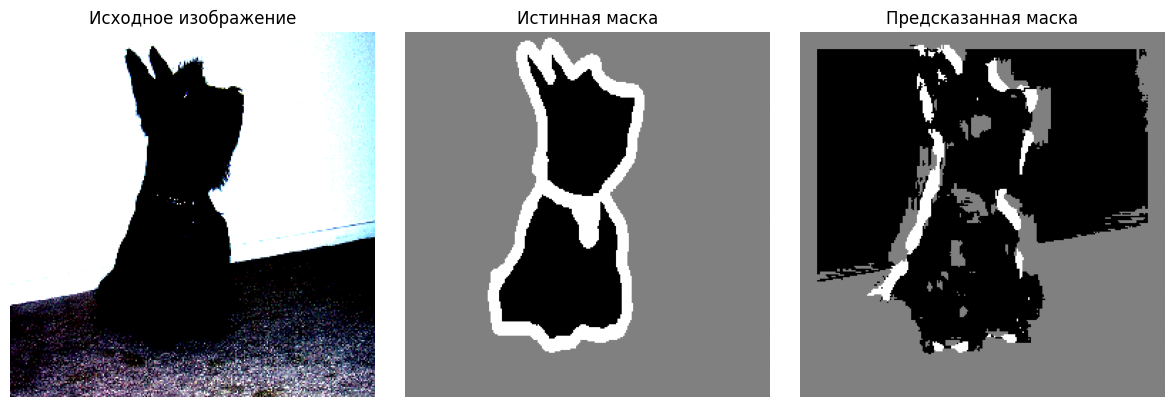

In [42]:
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, device):
    model.eval()
    img, true_mask = dataset[666]
    with torch.no_grad():
        img_input = img.unsqueeze(0).to(device)
        pred = model(img_input)
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    true_mask = true_mask.numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].set_title("Исходное изображение")
    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("Истинная маска")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Предсказанная маска")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_prediction(model, val_ds, device)

# Трансформеры

In [45]:
class PetSegmentationDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform_img=None, transform_mask=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx])  # класс: 1..3

        if self.transform_img:
            img = self.transform_img(img)
        mask = np.array(mask)
        mask = mask - 1  # приводим к 0..2
        mask = torch.from_numpy(mask).long()
        if self.transform_mask:
            mask = self.transform_mask(mask.unsqueeze(0)).squeeze(0).long()

        return img, mask


In [46]:
transform_img = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
transform_mask = transforms.Compose([
    transforms.Resize((128,128), interpolation=transforms.InterpolationMode.NEAREST)
])

train_ds = PetSegmentationDataset(imgs_train, masks_train, transform_img, transform_mask)
val_ds = PetSegmentationDataset(imgs_val, masks_val, transform_img, transform_mask)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)


In [48]:
num_classes = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Segformer(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    decoder_channels=(256, 128, 64, 32, 16),
    in_channels=3,
    classes=num_classes,
    decoder_use_batchnorm=True,
    architecture_type='segnet'
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [49]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    acc = 0.0
    miou = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item() * imgs.size(0)
            acc += pixel_accuracy(preds, masks) * imgs.size(0)
            miou += mean_iou(preds, masks) * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    acc /= len(val_loader.dataset)
    miou /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {acc:.4f}, mIoU: {miou:.4f}\n")

Val Epoch 1: 100%|██████████| 92/92 [00:03<00:00, 25.43it/s]


Epoch 1/5
Train Loss: 0.3937
Val Loss: 0.3485, Acc: 0.8616, mIoU: 0.6572



Val Epoch 2: 100%|██████████| 92/92 [00:03<00:00, 25.27it/s]


Epoch 2/5
Train Loss: 0.3094
Val Loss: 0.2826, Acc: 0.8908, mIoU: 0.7016



Val Epoch 3: 100%|██████████| 92/92 [00:05<00:00, 17.97it/s]


Epoch 3/5
Train Loss: 0.2813
Val Loss: 0.3007, Acc: 0.8849, mIoU: 0.6878



Val Epoch 4: 100%|██████████| 92/92 [00:03<00:00, 25.87it/s]


Epoch 4/5
Train Loss: 0.2493
Val Loss: 0.3074, Acc: 0.8826, mIoU: 0.6826



Val Epoch 5: 100%|██████████| 92/92 [00:03<00:00, 25.81it/s]

Epoch 5/5
Train Loss: 0.2446
Val Loss: 0.3052, Acc: 0.8848, mIoU: 0.6852



# Acc: 0.8848, mIoU: 0.6852

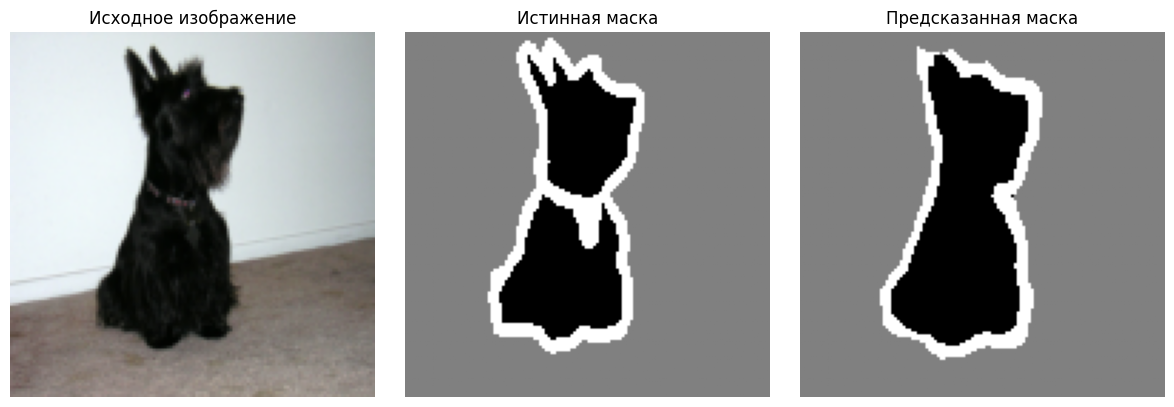

In [50]:
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, device):
    model.eval()
    img, true_mask = dataset[666]
    with torch.no_grad():
        img_input = img.unsqueeze(0).to(device)
        pred = model(img_input)
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    # Преобразование маски к numpy
    true_mask = true_mask.numpy()

    # Визуализация
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].set_title("Исходное изображение")
    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("Истинная маска")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Предсказанная маска")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_prediction(model, val_ds, device)

# Улучшенный бейзлайн

In [52]:
class PetSegmentationDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.img_paths[idx]).convert('RGB'))
        mask = np.array(Image.open(self.mask_paths[idx])) - 1  # Классы от 0 до 2

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].long()

        return img, mask

In [53]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_ds = PetSegmentationDataset(imgs_train, masks_train, transform=train_transform)
val_ds = PetSegmentationDataset(imgs_val, masks_val, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)


In [55]:
num_classes = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Segformer(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    decoder_channels=(256, 128, 64, 32, 16),
    in_channels=3,
    classes=num_classes,
    decoder_use_batchnorm=True,
    architecture_type='segnet'
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [56]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    acc = 0.0
    miou = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item() * imgs.size(0)
            acc += pixel_accuracy(preds, masks) * imgs.size(0)
            miou += mean_iou(preds, masks) * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    acc /= len(val_loader.dataset)
    miou /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {acc:.4f}, mIoU: {miou:.4f}\n")

Val Epoch 1: 100%|██████████| 92/92 [00:05<00:00, 16.74it/s]


Epoch 1/5
Train Loss: 0.3992
Val Loss: 0.3532, Acc: 0.8652, mIoU: 0.6679



Val Epoch 2: 100%|██████████| 92/92 [00:05<00:00, 16.23it/s]


Epoch 2/5
Train Loss: 0.3201
Val Loss: 0.2944, Acc: 0.8860, mIoU: 0.6989



Val Epoch 3: 100%|██████████| 92/92 [00:04<00:00, 18.78it/s]


Epoch 3/5
Train Loss: 0.2997
Val Loss: 0.2517, Acc: 0.9031, mIoU: 0.7312



Val Epoch 4: 100%|██████████| 92/92 [00:06<00:00, 14.76it/s]


Epoch 4/5
Train Loss: 0.2864
Val Loss: 0.2895, Acc: 0.8883, mIoU: 0.7137



Val Epoch 5: 100%|██████████| 92/92 [00:04<00:00, 18.71it/s]

Epoch 5/5
Train Loss: 0.2763
Val Loss: 0.2443, Acc: 0.9059, mIoU: 0.7382



# Acc: 0.9059, mIoU: 0.7382

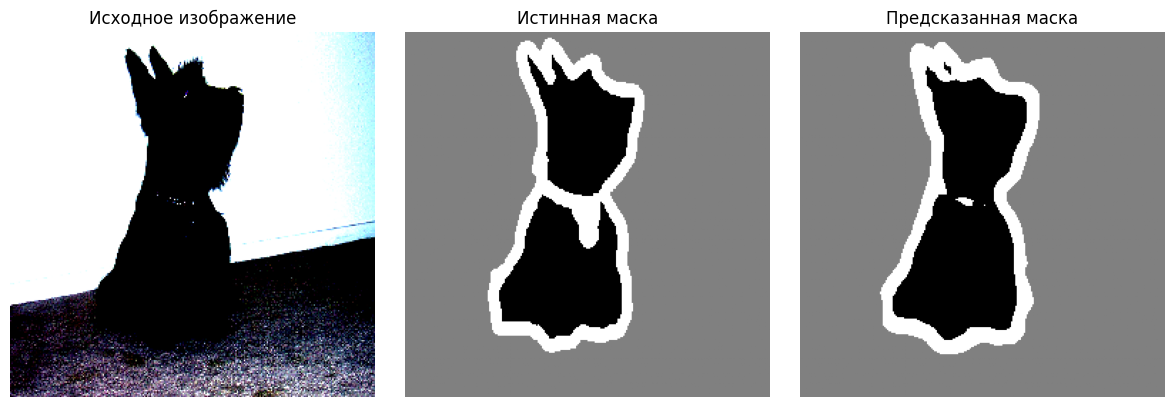

In [57]:
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, device):
    model.eval()
    img, true_mask = dataset[666]
    with torch.no_grad():
        img_input = img.unsqueeze(0).to(device)
        pred = model(img_input)
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    # Преобразование маски к numpy
    true_mask = true_mask.numpy()

    # Визуализация
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].set_title("Исходное изображение")
    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("Истинная маска")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Предсказанная маска")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_prediction(model, val_ds, device)

# Кастомный трансформер

In [67]:
class PetSegmentationDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx])
        mask = np.array(mask) - 1  # классы 0,1,2

        if self.transform:
            img, mask = self.transform(img, Image.fromarray(mask))
        return img, mask

In [66]:
class CustomSegmentationTransform:
    def __init__(self, resize=(256, 256), hflip_prob=0.5, rotation=20):
        self.resize = resize
        self.hflip_prob = hflip_prob
        self.rotation = rotation

    def __call__(self, image, mask):
        image = TF.resize(image, self.resize)
        mask = TF.resize(mask, self.resize, interpolation=Image.NEAREST)

        if random.random() < self.hflip_prob:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        angle = random.uniform(-self.rotation, self.rotation)
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle, interpolation=Image.NEAREST)

        image = TF.to_tensor(image)
        mask = torch.from_numpy(np.array(mask)).long()

        image = TF.normalize(image, mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        return image, mask


In [68]:
class CustomSegNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = conv_block(256, 128)
        self.dec2 = conv_block(128, 64)
        self.final = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        x1 = self.enc1(x)            # 256 -> 256
        x2 = self.enc2(self.pool(x1))# 256 -> 128
        x3 = self.enc3(self.pool(x2))# 128 -> 64
        b = self.pool(x3)            # 64 -> 32
        u3 = self.up(b)              # 32 -> 64
        d3 = self.dec3(u3)           # -> 64
        u2 = self.up(d3)             # 64 -> 128
        d2 = self.dec2(u2)           # -> 128
        u1 = self.up(d2)             # 128 -> 256
        out = self.final(u1)         # -> 256
        return out

In [79]:
num_classes = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomSegNet(in_channels=3, num_classes=num_classes).to(device)
class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = smp.losses.DiceLoss(mode='multiclass')
        self.ce = nn.CrossEntropyLoss()

    def forward(self, preds, targets):
        ce_loss = self.ce(preds, targets)
        dice_loss = self.dice(preds, targets)
        return ce_loss + dice_loss

criterion = CombinedLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [81]:
import torch.nn.functional as F


best_miou=0; counter=0; patience=5; num_epochs=5
for epoch in range(num_epochs):
    model.train(); train_loss=0
    for imgs,masks in tqdm(train_loader, desc=f"Train {epoch+1}"):
        imgs,masks=imgs.to(device),masks.to(device)
        preds=model(imgs); loss=criterion(preds,masks)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss+=loss.item()*imgs.size(0)
    train_loss/=len(train_loader.dataset)
    model.eval(); val_loss=acc=miou=0
    with torch.no_grad():
        for imgs,masks in tqdm(val_loader, desc=f"Val {epoch+1}"):
            imgs,masks=imgs.to(device),masks.to(device)
            preds=model(imgs); loss=criterion(preds,masks)
            val_loss+=loss.item()*imgs.size(0)
            acc+=((preds.argmax(1)==masks).float().mean().item()*imgs.size(0))
            miou+= (mean_iou(preds, masks) * imgs.size(0))
    val_loss/=len(val_loader.dataset)
    acc/=len(val_loader.dataset)
    miou/=len(val_loader.dataset)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1},, Val Loss {val_loss:.4f}, Acc {acc:.4f}, mIoU {miou:.4f}")
    if miou>best_miou: best_miou=miou; torch.save(model.state_dict(),'best.pth'); counter=0
    else: counter+=1
    if counter>=patience: print("Early stop"); break


Val 1: 100%|██████████| 92/92 [00:06<00:00, 14.81it/s]


Epoch 1,, Val Loss 0.8667, Acc 0.7891, mIoU 0.5687


Val 2: 100%|██████████| 92/92 [00:06<00:00, 13.47it/s]


Epoch 2,, Val Loss 0.8213, Acc 0.8090, mIoU 0.5936


Val 3: 100%|██████████| 92/92 [00:06<00:00, 13.17it/s]


Epoch 3,, Val Loss 0.8053, Acc 0.8115, mIoU 0.5993


Val 4: 100%|██████████| 92/92 [00:06<00:00, 13.94it/s]


Epoch 4,, Val Loss 0.8940, Acc 0.7845, mIoU 0.5719


Val 5: 100%|██████████| 92/92 [00:06<00:00, 14.84it/s]

Epoch 5,, Val Loss 0.7230, Acc 0.8396, mIoU 0.6315


# Acc 0.8396, mIoU 0.6315

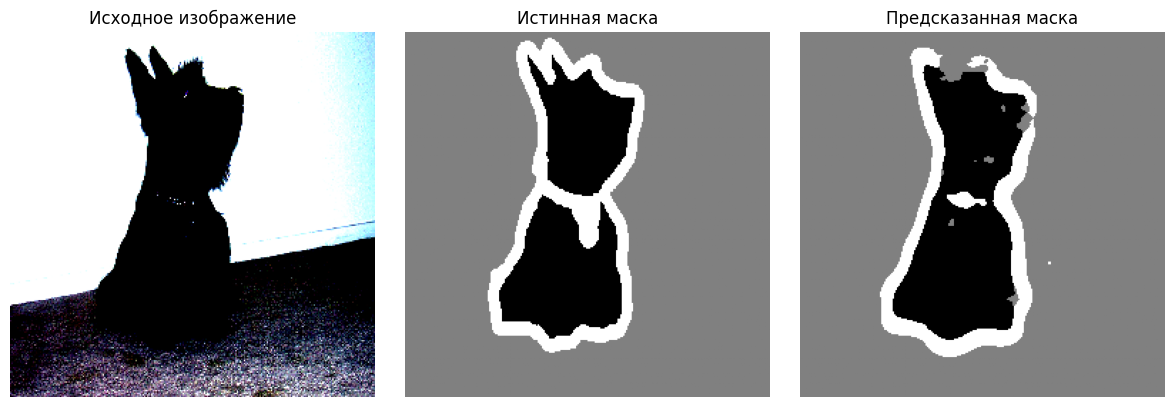

In [82]:
def visualize_prediction(model, dataset, device):
    model.eval()
    img, true_mask = dataset[666]
    with torch.no_grad():
        img_input = img.unsqueeze(0).to(device)
        pred = model(img_input)
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    true_mask = true_mask.numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].set_title("Исходное изображение")
    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("Истинная маска")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Предсказанная маска")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_prediction(model, val_ds, device)

# Улучшенный трансформер

In [83]:
class PetSegmentationDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.img_paths[idx]).convert('RGB'))
        mask = np.array(Image.open(self.mask_paths[idx])) - 1  # Классы от 0 до 2

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].long()

        return img, mask

In [85]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_ds = PetSegmentationDataset(imgs_train, masks_train, transform=train_transform)
val_ds = PetSegmentationDataset(imgs_val, masks_val, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [86]:
num_classes = 3
device = torch.device('cuda')
model = CustomSegNet(in_channels=3, num_classes=num_classes).to(device)
class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = smp.losses.DiceLoss(mode='multiclass')
        self.ce = nn.CrossEntropyLoss()

    def forward(self, preds, targets):
        ce_loss = self.ce(preds, targets)
        dice_loss = self.dice(preds, targets)
        return ce_loss + dice_loss

criterion = CombinedLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [87]:
import torch.nn.functional as F


best_miou=0; counter=0; patience=5; num_epochs=5
for epoch in range(num_epochs):
    model.train(); train_loss=0
    for imgs,masks in tqdm(train_loader, desc=f"Train {epoch+1}"):
        imgs,masks=imgs.to(device),masks.to(device)
        preds=model(imgs); loss=criterion(preds,masks)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss+=loss.item()*imgs.size(0)
    train_loss/=len(train_loader.dataset)
    model.eval(); val_loss=acc=miou=0
    with torch.no_grad():
        for imgs,masks in tqdm(val_loader, desc=f"Val {epoch+1}"):
            imgs,masks=imgs.to(device),masks.to(device)
            preds=model(imgs); loss=criterion(preds,masks)
            val_loss+=loss.item()*imgs.size(0)
            acc+=((preds.argmax(1)==masks).float().mean().item()*imgs.size(0))
            miou+= (mean_iou(preds, masks) * imgs.size(0))
    val_loss/=len(val_loader.dataset)
    acc/=len(val_loader.dataset)
    miou/=len(val_loader.dataset)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1},, Val Loss {val_loss:.4f}, Acc {acc:.4f}, mIoU {miou:.4f}")
    if miou>best_miou: best_miou=miou; torch.save(model.state_dict(),'best.pth'); counter=0
    else: counter+=1
    if counter>=patience: print("Early stop"); break


Val 1: 100%|██████████| 92/92 [00:06<00:00, 13.92it/s]


Epoch 1,, Val Loss 1.3599, Acc 0.6251, mIoU 0.3492


Val 2: 100%|██████████| 92/92 [00:07<00:00, 11.62it/s]


Epoch 2,, Val Loss 1.2218, Acc 0.6618, mIoU 0.4208


Val 3: 100%|██████████| 92/92 [00:06<00:00, 13.49it/s]


Epoch 3,, Val Loss 1.0433, Acc 0.7434, mIoU 0.5046


Val 4: 100%|██████████| 92/92 [00:06<00:00, 14.91it/s]


Epoch 4,, Val Loss 0.9403, Acc 0.7804, mIoU 0.5418


Val 5: 100%|██████████| 92/92 [00:06<00:00, 14.84it/s]

Epoch 5,, Val Loss 0.8775, Acc 0.7955, mIoU 0.5771


# Acc 0.7955, mIoU 0.5771

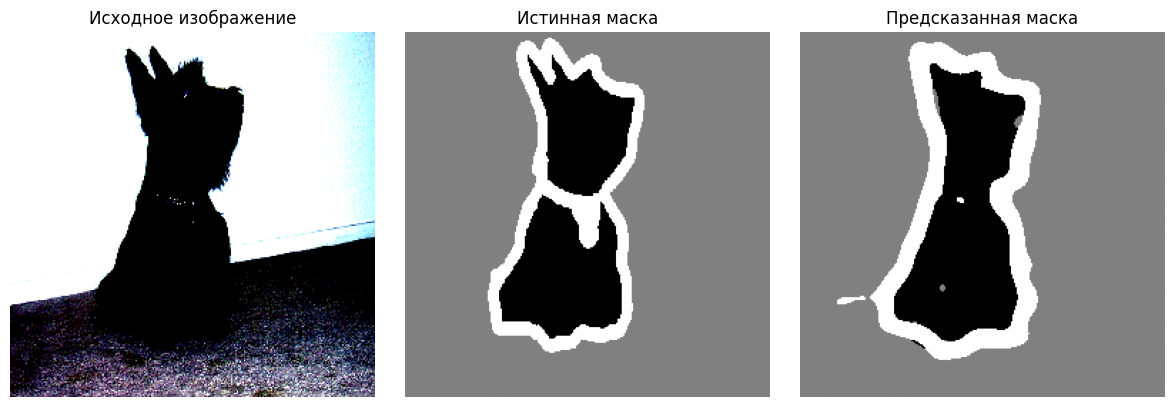

In [88]:
def visualize_prediction(model, dataset, device):
    model.eval()
    img, true_mask = dataset[666]
    with torch.no_grad():
        img_input = img.unsqueeze(0).to(device)
        pred = model(img_input)
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    true_mask = true_mask.numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].set_title("Исходное изображение")
    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("Истинная маска")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Предсказанная маска")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_prediction(model, val_ds, device)

# Результаты
|Модель|Acc|mIoU|
|-|-|-|
|Unet|0.8837|0.6894|
|Unet ул.|0.8230|0.5814|
|Custom Unet|0.7617|0.4692|
|Custom Unet ул.|0.6885|0.4097|
|Segformer|0.8848|0.6852|
|Segformer ул.|0.9059|0.7382|
|Custom Segformer|0.8396|0.6315|
|Custom Segformer ул.|0.7955|0.5771|

## Выводы
Лучше всего показал себя Segformer с улучшенным бейзлайном, причем это единственный случай, когда улучшенный бейзлайн оказался лучше базовой реализации. Кастомные реализации в целом дают худший результат, чем библиотечные